# СМО с неограниченной взаимопощью

In [1]:
import simpy
import numpy as np
import math
from functools import reduce
from scipy.stats import chisquare
import matplotlib.pyplot as plt

## Модель СМО с неограниченной взаимопощью

In [2]:
class QS_with_help(object):
    def __init__(self, n, lambd, f_k, env):
        ##queuing system params
        self.n = n
        self.lambd = lambd
        self.f_k = f_k
        ##making requests simulation
        self.env = env
        self.loader = simpy.Resource(env, 1)
        ##observable values
        self.L_queuing_system_lst = []
        self.t_queuing_system_lst = []
    
    def request_processing(self):
        yield self.env.timeout(np.random.exponential(1/self.f_k(self.n)))
 

## Модель СМО без взаимопомощи

In [3]:
class QS_without_help(object):
    def __init__(self, n, lambd, mu, env):
        ##queuing system params
        self.n = n
        self.lambd = lambd
        self.mu = mu
        ##making requests simulation
        self.env = env
        self.loader = simpy.Resource(env, n)
        ##observable values
        self.L_queuing_system_lst = []
        self.t_queuing_system_lst = []
    
    def request_processing(self):
        yield self.env.timeout(np.random.exponential(1/self.mu))

## Модель процессов в СМО

In [4]:
def make_request(qs, env, with_help = True):
    n_occuped_before = qs.loader.count * (qs.n if with_help else 1)
    qs.L_queuing_system_lst.append(n_occuped_before)
    
    with qs.loader.request() as request:
        queque_len_after = len(qs.loader.queue)
        if queque_len_after <= 0:
            arrival_time = env.now
            
            yield request
            
            yield env.process(qs.request_processing())
            qs.t_queuing_system_lst.append(env.now - arrival_time)
            
        else:
            qs.t_queuing_system_lst.append(0)

In [5]:
def run_queuing_system(qs, env, with_help = True):
    while True:
        yield env.timeout(np.random.exponential(1/qs.lambd))
        env.process(make_request(qs, env, with_help))

## Тестовые функции

In [6]:
def test_qs_with_help(n, lambd, f_k, test_time):
    env = simpy.Environment()
    qs = QS_with_help(n, lambd, f_k, env) 
    env.process(run_queuing_system(qs, env))
    env.run(until=test_time)
    return qs.t_queuing_system_lst, qs.L_queuing_system_lst

In [7]:
def test_qs_without_help(n, lambd, mu, test_time):
    env = simpy.Environment()
    qs = QS_without_help(n, lambd, mu, env) 
    env.process(run_queuing_system(qs, env, with_help=False))
    env.run(until=test_time)
    return qs.t_queuing_system_lst, qs.L_queuing_system_lst

In [8]:
def get_chi2(theoretical_characteristic, empirical_characteristic):
    t_estimation_lst = theoretical_characteristic[0] + [
        theoretical_characteristic[i] for i in range(1, len(theoretical_characteristic))
    ]
    e_estimation_lst = empirical_characteristic[0] + [
        empirical_characteristic[i] for i in range(1, len(empirical_characteristic))
    ]
    return chisquare(e_estimation_lst, f_exp=t_estimation_lst)

## Характеристики СМО с неограниченной взаимопомощью

In [9]:
def get_e_char_with_help(test_results, n, lambd, f_k):
    t_queuing_system_lst, L_queuing_system_lst  = test_results
    p = []
    for i in range(2):
        request_frequency = reduce( lambda count, x: count+1 if x==i*n else count , L_queuing_system_lst, 0)
        p.append(request_frequency / len(L_queuing_system_lst))
    p_reject = p[-1]
    Q = 1 - p_reject
    A = lambd * Q
    n_occuped = Q * lambd / f_k(n)
    L_queuing_system = sum(L_queuing_system_lst) / len(L_queuing_system_lst)
    t_queuing_system = sum(t_queuing_system_lst) / len(t_queuing_system_lst)
    
    return p, A, p_reject, L_queuing_system, t_queuing_system, n_occuped

In [10]:
def get_t_char_with_help(n, lambd, f_k):
    p=[]
    p_0 = (1+lambd/f_k(n)) ** (-1)
    p.append(p_0)
    p_1 = lambd/f_k(n)*p_0
    p.append(p_1)
    
    p_reject = p[1]
    Q = 1 - p_reject
    A = lambd * Q
    n_occuped = Q * lambd / f_k(n)
    L_queuing_system = sum([k*n*p[k] for k in range(2)])
    t_queuing_system = L_queuing_system / lambd
    
    return p, A, p_reject, L_queuing_system, t_queuing_system, n_occuped

## Характеристики СМО без взаимопощи

In [11]:
def get_e_char_without_help(test_results, n, lambd, mu):
    t_queuing_system_lst, L_queuing_system_lst  = test_results
    p = []
    for i in range(n+1):
        request_frequency = reduce( lambda count, x: count+1 if x==i else count , L_queuing_system_lst, 0)
        p.append(request_frequency / len(L_queuing_system_lst))
    p_reject = p[-1]
    Q = 1 - p_reject
    A = lambd * Q
    n_occuped = Q * lambd / mu
    L_queuing_system = sum(L_queuing_system_lst) / len(L_queuing_system_lst)
    t_queuing_system = sum(t_queuing_system_lst) / len(t_queuing_system_lst)
    
    return p, A, p_reject, L_queuing_system, t_queuing_system, n_occuped

In [12]:
def get_t_char_without_help(n, lambd, mu):
    ro = lambd / mu
    p=[]
    
    p_0 = (sum([ ro ** i / math.factorial(i) for i in range (n+1)])) ** (-1)
    p.append(p_0)
    for k in range(1,n+1):
        p_k = ro ** k / math.factorial(k) * p[0]
        p.append(p_k)
    
    p_reject = p[-1]
    Q = 1 - p_reject
    A = lambd * Q
    n_occuped = Q * lambd / mu
    L_queuing_system = sum([k*p[k] for k in range(n+1)])
    t_queuing_system = L_queuing_system / lambd
    
    return p, A, p_reject, L_queuing_system, t_queuing_system, n_occuped

#### Результаты

In [13]:
def table_formation(values, row_labels, char_with_help, char_without_help, label):
    
    p_h, A_h, p_reject_h, L_queuing_system_h, t_queuing_system_h, n_occuped_h = char_with_help
    p, A, p_reject, L_queuing_system, t_queuing_system, n_occuped = char_without_help
    
    for i in range(len(p_h)):
        print( f'{label} p{(i)} of system with unlimited mutual help: {p_h[i]}')
    print()
    
    for i in range(len(p)):
        print( f'{label} p{(i)} of system without help: {p[i]}')
    print()
        
    row_labels.append(f'{label} A')
    values.append([A_h, A])
    row_labels.append(f'{label} p_reject')
    values.append([p_reject_h, p_reject])
    row_labels.append(f'{label} L_queuing_system')
    values.append([L_queuing_system_h, L_queuing_system])
    row_labels.append(f'{label} t_queuing_system')
    values.append([t_queuing_system_h, t_queuing_system])
    row_labels.append(f'{label} n_occuped')
    values.append([n_occuped_h, n_occuped])
    
    return values, row_labels

def display(t_char_with_help, e_char_with_help, t_char_without_help, e_char_without_help):
    col_labels = ['With unlimited mutual help', 'Without help']
    
    values = []
    row_labels = []
    
    
    values, row_labels = table_formation(values, row_labels, t_char_with_help, t_char_without_help, 'Theoretical')
    values, row_labels = table_formation(values, row_labels, e_char_with_help, e_char_without_help, 'Empirical')
    
    row_labels.append('Chi-square test')
    values.append([get_chi2(t_char_with_help, e_char_with_help), 
                   get_chi2(t_char_without_help, e_char_without_help)])
    
    fig, ax = plt.subplots( figsize=(16, 5) ) 
    ax.set_axis_off() 
    table = ax.table( 
        cellText = values,  
        rowLabels = row_labels,  
        colLabels = col_labels, 
        rowColours =["palegreen"] * len(row_labels),  
        colColours =["palegreen"] * len(col_labels), 
        cellLoc ='center',  
        loc ='upper left'
    )

## Тесты

### Тест №1
#### Сравнение системы с неограниченной взаимопомощью (n=2, $\lambda$=2, f(k)=k) и без (n=2, $\lambda$=2, $\mu$=1)

In [14]:
n, lambd, mu = 2, 2 , 1
f_k = lambda x: mu*x

t_char_with_help = get_t_char_with_help(n, lambd, f_k)
t_char_without_help = get_t_char_without_help(n, lambd, mu)

test_results_with_help = test_qs_with_help(n, lambd, f_k, 10000)
test_results_without_help = test_qs_without_help(n, lambd, mu, 10000)

e_char_with_help = get_e_char_with_help(test_results_with_help, n, lambd, f_k)
e_char_without_help = get_e_char_without_help(test_results_without_help, n, lambd, mu)

display(t_char_with_help, e_char_with_help, t_char_without_help, e_char_without_help)



Theoretical p0 of system with unlimited mutual help: 0.5
Theoretical p1 of system with unlimited mutual help: 0.5

Theoretical p0 of system without help: 0.2
Theoretical p1 of system without help: 0.4
Theoretical p2 of system without help: 0.4

Empirical p0 of system with unlimited mutual help: 0.49825592983854894
Empirical p1 of system with unlimited mutual help: 0.5017440701614511

Empirical p0 of system without help: 0.19861431870669746
Empirical p1 of system without help: 0.3954212270308264
Empirical p2 of system without help: 0.4059644542624761



ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.05910200408417233

### Тест №2
#### Сравнение системы с неограниченной взаимопомощью (n=3, $\lambda$=5, f(k)=2k) и без (n=3, $\lambda$=5, $\mu$=2)

In [ ]:
n, lambd, mu = 3, 5, 2
f_k = lambda x: mu * x

t_char_with_help = get_t_char_with_help(n, lambd, f_k)
t_char_without_help = get_t_char_without_help(n, lambd, mu)

test_results_with_help = test_qs_with_help(n, lambd, f_k, 10000)
test_results_without_help = test_qs_without_help(n, lambd, mu, 10000)

e_char_with_help = get_e_char_with_help(test_results_with_help, n, lambd, f_k)
e_char_without_help = get_e_char_without_help(test_results_without_help, n, lambd, mu)

display(t_char_with_help, e_char_with_help, t_char_without_help, e_char_without_help)

### Тест №3 (n=7, $\lambda$=12, f(k)=3k)
#### Сравнение системы с неограниченной взаимопомощью (n=7, $\lambda$=12, f(k)=3k) и без (n=7, $\lambda$=12, $\mu$=3)

In [ ]:
n, lambd, mu = 7, 12, 3
f_k = lambda x: mu * x

t_char_with_help = get_t_char_with_help(n, lambd, f_k)
t_char_without_help = get_t_char_without_help(n, lambd, mu)

test_results_with_help = test_qs_with_help(n, lambd, f_k, 10000)
test_results_without_help = test_qs_without_help(n, lambd, mu, 10000)

e_char_with_help = get_e_char_with_help(test_results_with_help, n, lambd, f_k)
e_char_without_help = get_e_char_without_help(test_results_without_help, n, lambd, mu)

display(t_char_with_help, e_char_with_help, t_char_without_help, e_char_without_help)

## Графики, которые показывают формирование установившегося состояния в СМО при неограниченной взаимопомощи

In [ ]:
n, lambd, f_k = 2, 1 , lambda x: x
times = [i*50 for i in range(1,201)]

p0, p1 = [],[]
for time in times:
    test_results = test_qs_with_help(n, lambd, f_k, time)
    empirical_characteristic = get_e_char_with_help(test_results, n, lambd, f_k)
    p0.append(empirical_characteristic[0][0])
    p1.append(empirical_characteristic[0][1])

p_theoretical = get_t_char_with_help(n, lambd, f_k)[0]

fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(16, 28), 
                                         gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1]}
                                        )
x = np.linspace(0, 10, 10000)

ax0.set_title('p0')
ax0.plot(times, [p_theoretical[0]]*len(times), '-k')
ax0.fill_between(times, y1=p0, color='b', step='post', alpha=0.5)

ax1.set_title('p1')
ax1.plot(times, [p_theoretical[1]]*len(times), '-k')
ax1.fill_between(times, y1=p1, color='r', step='post', alpha=0.5)

fig.tight_layout()

## Графики, которые показывают формирование установившегося состояния в СМО без взаимопомощи

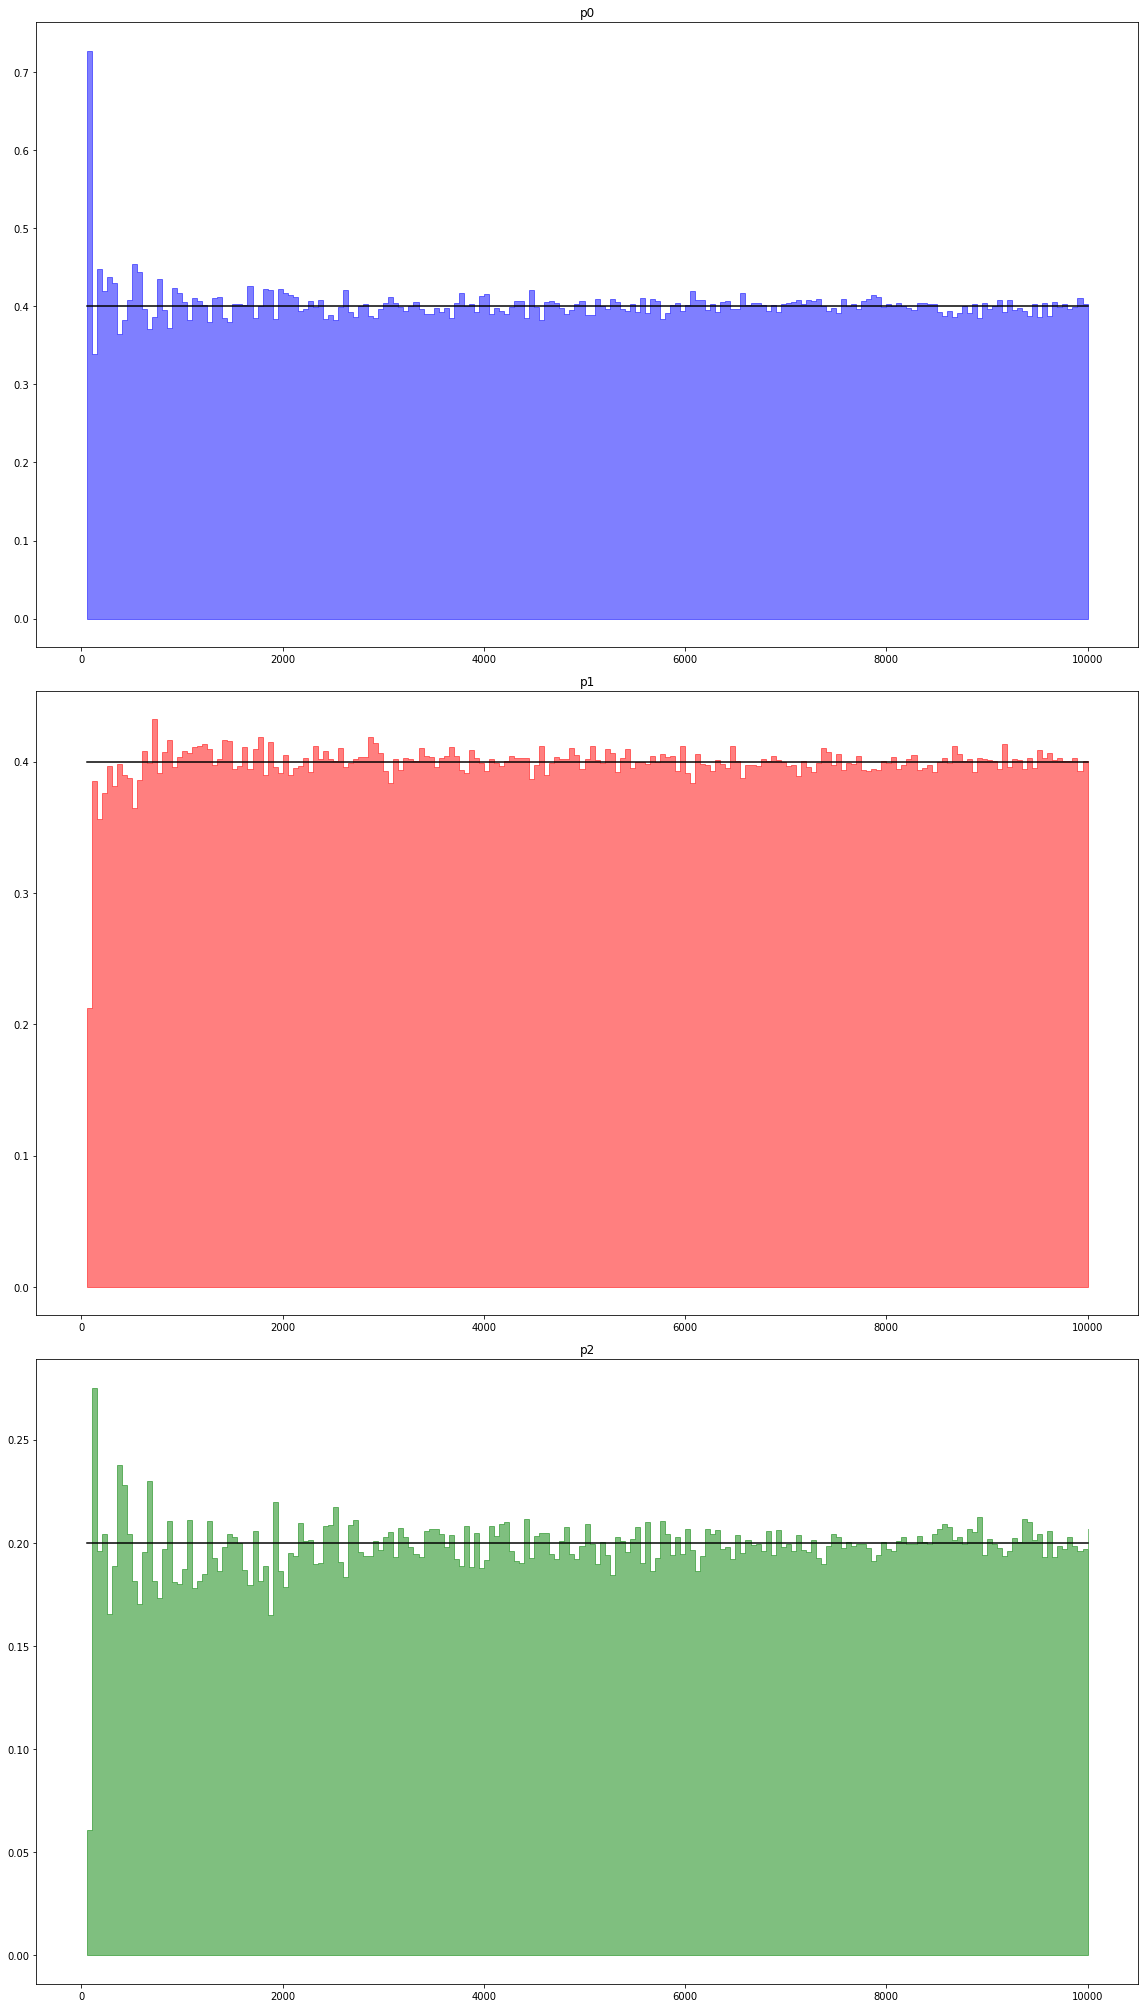

In [15]:
n, lambd, mu = 2, 1 , 1
times = [i*50 for i in range(1,201)]

p0, p1, p2 = [],[],[]
for time in times:
    test_results = test_qs_without_help(n, lambd, mu, time)
    empirical_characteristic = get_e_char_without_help(test_results, n, lambd, mu)
    p0.append(empirical_characteristic[0][0])
    p1.append(empirical_characteristic[0][1])
    p2.append(empirical_characteristic[0][2])

p_theoretical = get_t_char_without_help(n, lambd, mu)[0]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=1, nrows=3, figsize=(16, 28), 
                                         gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [1]}
                                        )
x = np.linspace(0, 10, 10000)

ax0.set_title('p0')
ax0.plot(times, [p_theoretical[0]]*len(times), '-k')
ax0.fill_between(times, y1=p0, color='b', step='post', alpha=0.5)

ax1.set_title('p1')
ax1.plot(times, [p_theoretical[1]]*len(times), '-k')
ax1.fill_between(times, y1=p1, color='r', step='post', alpha=0.5)

ax2.set_title('p2')
ax2.plot(times, [p_theoretical[2]]*len(times), '-k')
ax2.fill_between(times, y1=p2, color='g', step='post', alpha=0.5)

fig.tight_layout()

